## Statistical analysis of the player paths data

In [1]:
import pandas as pd
import pyarrow.feather as feather
import matplotlib.pyplot as plt

In [2]:
#reload stored dataframes
article_df = feather.read_feather('Data/dataframes/article_dataframe.feather')
paths_df = feather.read_feather('Data/dataframes/paths.feather')

**Before doing analysis we add some usefull columns to the data frame**
- an identifier column for the same start and target pairs
- a column where the full path is converted into a list
- a column where only the direct path (no backward clicks) are considered and converted into a list
- respectively a column for the length of the two lists (path legths) described just above

In [3]:
# to have unique indexes
paths_df = paths_df.reset_index(drop=True)

# add an identifier for the same start-target articles pairs
paths_df['identifier'] = paths_df.groupby(['start_article', 'target_article']).ngroup()

In [4]:
# should be moved to some other place later

def process_path(path_string):
    # Split the input string by the ";" delimiter
    links = path_string.split(";")
    
    # Initialize lists for full path and simplified path
    full_path = []
    simplified_path = []
    
    # Traverse through each link in the path
    for link in links:
        # Handle backward steps
        if link == "<":
            if simplified_path: # make sure list is not empty befor pop
                simplified_path.pop()  # Go back by removing last entry
        else:
            full_path.append(link)
            simplified_path.append(link)
    
    return full_path, simplified_path

In [5]:
# add two new columns to the paths dataset with processed paths
paths_df[['full_path', 'simplified_path']] = paths_df['path'].apply(lambda x: pd.Series(process_path(x)))

# also add a column of for full and simplified path length
paths_df['full_path_length'] = paths_df['full_path'].apply(lambda x: len(x))
paths_df['simplified_path_length'] = paths_df['simplified_path'].apply(lambda x: len(x))

In [6]:
paths_df.head(1)

,hashedIpAddress,timestamp,durationInSec,path,rating,finished,failure_reason,start_article,target_article,identifier,full_path,simplified_path,full_path_length,simplified_path_length
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,True,None,14th_century,African_slave_trade,48,"[14th_century, 15th_century, 16th_century, Pac...","[14th_century, 15th_century, 16th_century, Pac...",9,9


In [7]:
# check if it worked for a path with backward steps
p = paths_df.loc[16]
print(f"Original String Path:\n    {p['path']}\n")
print(f"Converted Full Path:\n    {p['full_path']}\n")
print(f"Converted Simplified Path:\n    {p['simplified_path']}\n")

Original String Path:
    14th_century;Europe;Republic_of_Ireland;<;<;Europe;<;Europe;Republic_of_Ireland;<;<;Time;Physics;Speed_of_light;Rainbow

Converted Full Path:
    ['14th_century', 'Europe', 'Republic_of_Ireland', 'Europe', 'Europe', 'Republic_of_Ireland', 'Time', 'Physics', 'Speed_of_light', 'Rainbow']

Converted Simplified Path:
    ['14th_century', 'Time', 'Physics', 'Speed_of_light', 'Rainbow']



### Outlier handling
before jumping into distribution analysis let's first see if there are potential outliers that need to be taken care of, this is easier when considering finished and unfinished paths seperately

In [8]:
paths_df['full_path_length'].describe()

finished_paths = paths_df[paths_df['finished']]
unfinished_paths = paths_df[~paths_df['finished']]

print(f"Finished path length statistics:\n    {finished_paths[['full_path_length', 'simplified_path_length']].describe()}\n")
print(f"Unfinished path length statistics:\n    {unfinished_paths[['full_path_length', 'simplified_path_length']].describe()}\n")



Finished path length statistics:
           full_path_length  simplified_path_length
count      51318.000000            51318.000000
mean           6.356775                5.956117
std            3.775778                3.288758
min            1.000000                1.000000
25%            4.000000                4.000000
50%            6.000000                5.000000
75%            7.000000                7.000000
max          420.000000              405.000000

Unfinished path length statistics:
           full_path_length  simplified_path_length
count      24875.000000            24875.000000
mean           4.678915                4.160040
std            4.595089                3.942539
min            1.000000                1.000000
25%            2.000000                2.000000
50%            4.000000                3.000000
75%            6.000000                5.000000
max          192.000000              149.000000



In [9]:
# there are some very long paths lets analyse them in more detail
finished_paths.sort_values(by='full_path_length', ascending=False).head(6)

,hashedIpAddress,timestamp,durationInSec,path,rating,finished,failure_reason,start_article,target_article,identifier,full_path,simplified_path,full_path_length,simplified_path_length
8046,7f6da01d55086766,1248928447,2205,"United_States;Washington,_D.C.;Government;Corp...",5.0,True,None,United_States,English_language,39775,"[United_States, Washington,_D.C., Government, ...","[United_States, Washington,_D.C., Government, ...",420,405
19961,4f1b9ce764349901,1236685130,2292,Napoleon_I_of_France;United_Kingdom;Great_Brit...,NaN,True,None,Napoleon_I_of_France,Recycling,26826,"[Napoleon_I_of_France, United_Kingdom, Great_B...","[Napoleon_I_of_France, United_Kingdom, Great_B...",114,109
6945,4e97d9af4476607f,1248925083,1141,"Police_state;Police;United_States;Washington,_...",5.0,True,None,Police_state,African_slave_trade,30473,"[Police_state, Police, United_States, Washingt...","[Police_state, Police, United_States, Washingt...",103,102
27136,0d57c8c57d75e2f5,1290096241,1852,Lake_Toba;Netherlands;Europe;Earth;United_Stat...,5.0,True,None,Lake_Toba,Looney_Tunes,22232,"[Lake_Toba, Netherlands, Europe, Earth, United...","[Lake_Toba, Netherlands, Europe, Earth, United...",91,83
6659,7f6da01d55086766,1248923237,364,North_America;Pacific_Ocean;Earth;Earth's_atmo...,5.0,True,None,North_America,Canada,27769,"[North_America, Pacific_Ocean, Earth, Earth's_...","[North_America, Pacific_Ocean, Earth, Earth's_...",72,72
28393,7b740aba73fe91e2,1231967436,171,55_Cancri_c;Saturn;Zeus;Heracles;Rome;Christia...,1.0,True,None,55_Cancri_c,Niger,456,"[55_Cancri_c, Saturn, Zeus, Heracles, Rome, Ch...","[55_Cancri_c, Saturn, Zeus, Heracles, Rome, Ch...",65,63


In [10]:
# Judjing from the start-end article pairs these paths don't seem to be very complicated and are clear outliers that
# where probably purposfully added
# to confirm this lets look at the statistics of some of the paths with the same identifier:

print(f"Statistics of all paths that have the same start-target article pair as the longest path:\n    {finished_paths[finished_paths['identifier'] == 39775][['full_path_length', 'simplified_path_length']].describe()}\n")

print(f"Statistics of all paths that have the same start-target article pair as the 2nd longest path:\n    {finished_paths[finished_paths['identifier'] == 26826][['full_path_length', 'simplified_path_length']].describe()}\n")


Statistics of all paths that have the same start-target article pair as the longest path:
           full_path_length  simplified_path_length
count         15.000000               15.000000
mean          30.933333               29.933333
std          107.632620              103.759658
min            3.000000                3.000000
25%            3.000000                3.000000
50%            3.000000                3.000000
75%            3.000000                3.000000
max          420.000000              405.000000

Statistics of all paths that have the same start-target article pair as the 2nd longest path:
           full_path_length  simplified_path_length
count           4.00000                4.000000
mean           36.50000               35.000000
std            52.04165               49.672259
min             4.00000                4.000000
25%             7.75000                7.750000
50%            14.00000               13.500000
75%            42.75000               4

From the above we estimate that a smart way to handle outliers is to use the interquantile range (IQR) method method removing paths which have a length of more than 75% quantile + 1.5 x IQR. There are two possible approaches either to define global outlier or to define outliers per start-target article pair group. The latter however only makes sense if there are enough samples present per group. 

Since there are certainly differences in path difficulty between the groups the second appraoch would be more taylored but it requires a certain number of samples per group to be somewhat accurate.  Thus we first have a look at the statistics of start-target article pair group size.

In [31]:
# Get the counts of each identifier
pair_identifier_counts = finished_paths.groupby('identifier').size()

pair_identifier_counts.describe()

count    28718.000000
mean         1.786963
std         11.128460
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1043.000000
dtype: float64

In [12]:
# Since overall there clearly is a very low amount of sample (close to 1) per start-target pair group, we have to use the global approach (for now)

Q1 = finished_paths['full_path_length'].quantile(0.25)
Q3 = finished_paths['full_path_length'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = round(Q3 + 1.5 * IQR)

filtered_finished_paths = finished_paths[(finished_paths['full_path_length'] <= upper_bound)]

removed = finished_paths.shape[0] - filtered_finished_paths.shape[0]

print(f"A total of {removed} paths were removed, "
      f"which represents {removed / finished_paths.shape[0] * 100:.3f}% of the original data.")

filtered_finished_paths[['full_path_length', 'simplified_path_length']].describe()

A total of 2042 paths were removed, which represents 3.979% of the original data.


,full_path_length,simplified_path_length
count,49276.000000,49276.000000
mean,5.895710,5.631646
std,2.067099,1.870788
min,1.000000,1.000000
25%,4.000000,4.000000
50%,6.000000,5.000000
75%,7.000000,7.000000
max,12.000000,12.000000


In [13]:
# do something similar for the unfinished paths but here we also put a lower bound
Q1 = unfinished_paths['full_path_length'].quantile(0.25)
Q3 = unfinished_paths['full_path_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = 3 # NOTE: for now this is kinda arbitrary!
upper_bound = round(Q3 + 1.5 * IQR)

filtered_unfinished_paths = unfinished_paths[(unfinished_paths['full_path_length'] <= upper_bound) & 
                                         (unfinished_paths['full_path_length'] >= lower_bound)]

removed = unfinished_paths.shape[0] - filtered_unfinished_paths.shape[0]

print(f"A total of {removed} paths were removed, "
      f"which represents {removed / unfinished_paths.shape[0] * 100:.3f}% of the original data.")

filtered_unfinished_paths[['full_path_length', 'simplified_path_length']].describe()

A total of 9882 paths were removed, which represents 39.727% of the original data.


,full_path_length,simplified_path_length
count,14993.000000,14993.000000
mean,5.561129,5.006069
std,2.353246,2.217292
min,3.000000,1.000000
25%,4.000000,3.000000
50%,5.000000,5.000000
75%,7.000000,6.000000
max,12.000000,12.000000


### Analysis of the path length distributions

We will do so starting with the finished paths. where the goal is to get a histogram of the path lengths and compute some relevant statistics.
It is interesting to look at the total number of links that where used, as well as the actual distance of the path that was taken in the end (so without considering back clicks)

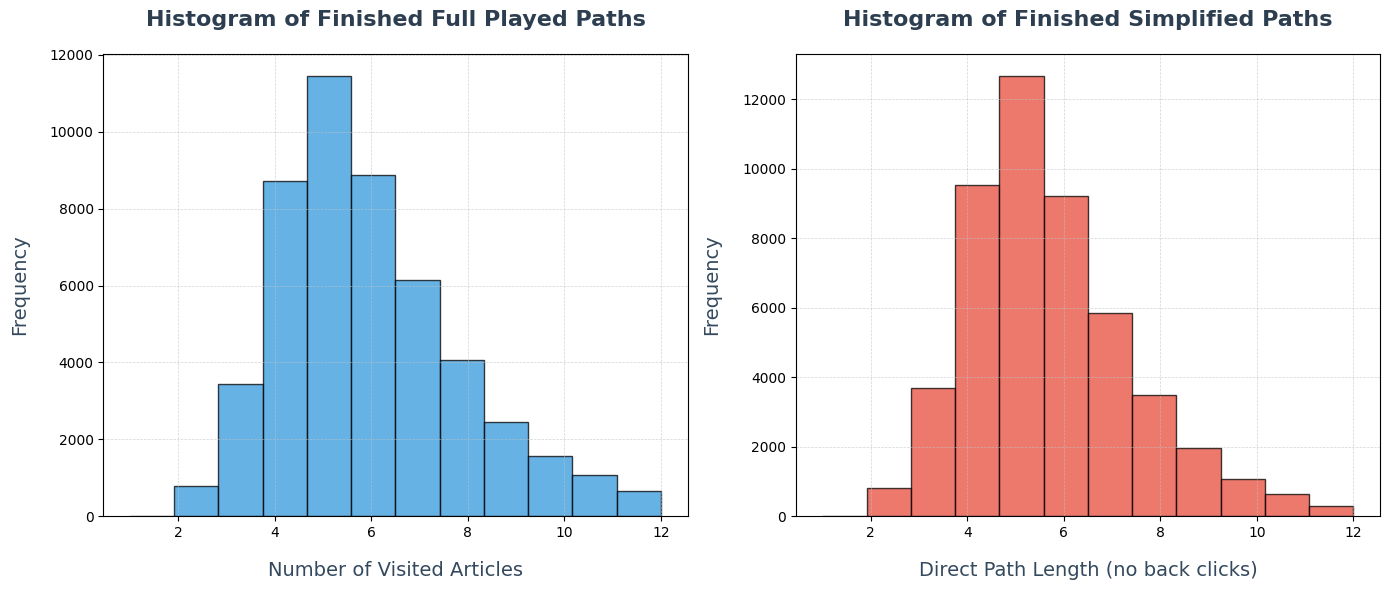

In [14]:
len_full_finished = pd.Series(filtered_finished_paths['full_path'].apply(lambda x: len(x)))
len_simplified_finished = pd.Series(filtered_finished_paths['simplified_path'].apply(lambda x: len(x)))

# Create a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the histogram for full path lengths on the first subplot
len_full_finished.plot(kind='hist', bins=12, color='#3498db', edgecolor='black', alpha=0.75, ax=axes[0])
axes[0].set_title("Histogram of Finished Full Played Paths", fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
axes[0].set_xlabel("Number of Visited Articles", fontsize=14, color='#34495E', labelpad=15)
axes[0].set_ylabel("Frequency", fontsize=14, color='#34495E', labelpad=15)
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')  # Subtle gridlines

# Plot the histogram for simplified path lengths on the second subplot
len_simplified_finished.plot(kind='hist', bins=12, color='#e74c3c', edgecolor='black', alpha=0.75, ax=axes[1])
axes[1].set_title("Histogram of Finished Simplified Paths", fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
axes[1].set_xlabel("Direct Path Length (no back clicks)", fontsize=14, color='#34495E', labelpad=15)
axes[1].set_ylabel("Frequency", fontsize=14, color='#34495E', labelpad=15)
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')  # Subtle gridlines

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

This looks pretty good! The cutoff seems reasonable.
We can now do the same for unfinished articles:

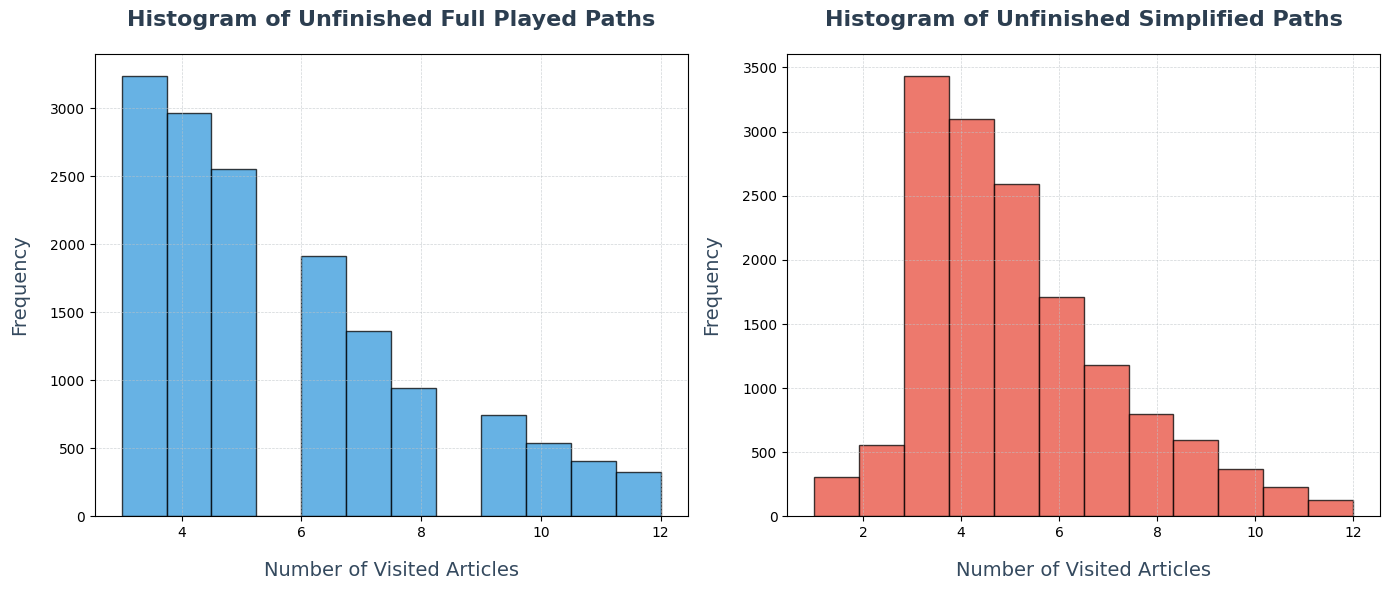

In [15]:
len_full_unfinished = pd.Series(filtered_unfinished_paths['full_path'].apply(lambda x: len(x)))
len_simplified_unfinished = pd.Series(filtered_unfinished_paths['simplified_path'].apply(lambda x: len(x)))

# Create a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the histogram for full path lengths on the first subplot
len_full_unfinished.plot(kind='hist', bins=12, color='#3498db', edgecolor='black', alpha=0.75, ax=axes[0])
axes[0].set_title("Histogram of Unfinished Full Played Paths", fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
axes[0].set_xlabel("Number of Visited Articles", fontsize=14, color='#34495E', labelpad=15)
axes[0].set_ylabel("Frequency", fontsize=14, color='#34495E', labelpad=15)
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')  # Subtle gridlines

# Plot the histogram for simplified path lengths on the second subplot
len_simplified_unfinished.plot(kind='hist', bins=12, color='#e74c3c', edgecolor='black', alpha=0.75, ax=axes[1])
axes[1].set_title("Histogram of Unfinished Simplified Paths", fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
axes[1].set_xlabel("Number of Visited Articles", fontsize=14, color='#34495E', labelpad=15)
axes[1].set_ylabel("Frequency", fontsize=14, color='#34495E', labelpad=15)
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')  # Subtle gridlines

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

**Comment:** 
There is obviously some weird stuff going on here for the unfinished paths but as long as we're not sure if we use them it makes little sense to waste time on this

**TO DO:** concat the filtered data frames.

## Start-Target article analysis

We are interested in the distribution of the number of times the same start-target article pairs appear. Ideally this would be somewhat uniform.

In [25]:
start_target_groups = paths_df.groupby(['start_article', 'target_article'])
start_articles_groups = paths_df.groupby(['start_article'])
target_articles_groups = paths_df.groupby(['target_article'])


print(f"Start-Target pair group size statistics:\n    {start_target_groups.size().describe()}\n")
print(f"Sart article's group size statistics:\n    {start_articles_groups.size().describe()}\n")
print(f"Target article's group size statistics:\n    {target_articles_groups.size().describe()}\n")



Start-Target pair group size statistics:
    count    42630.000000
mean         1.787309
std         17.659746
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       2044.000000
dtype: float64

Sart article's group size statistics:
    count    4168.000000
mean       18.280470
std        60.566768
min         1.000000
25%         9.000000
50%        13.000000
75%        20.000000
max      2113.000000
dtype: float64

Target article's group size statistics:
    count    3997.000000
mean       19.062547
std        62.691282
min         1.000000
25%         7.000000
50%        12.000000
75%        21.000000
max      2194.000000
dtype: float64



Clearly the distribution is not unfirom at all. Most games from a certain start article to target article were only attempted once but we also see that some are played over 1000 times! We can now try to find the most played paths and maybe already find out why they are played much more often.

In [26]:
paths_df.head(1)

,hashedIpAddress,timestamp,durationInSec,path,rating,finished,failure_reason,start_article,target_article,identifier,full_path,simplified_path,full_path_length,simplified_path_length
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,True,None,14th_century,African_slave_trade,48,"[14th_century, 15th_century, 16th_century, Pac...","[14th_century, 15th_century, 16th_century, Pac...",9,9


In [30]:
# Group by 'start_article' and 'target_article' and aggregate
grouped = start_target_groups.agg(
    group_size=('target_article', 'size'),                      # Size of each group
    mean_full_path_length=('full_path_length', 'mean'),         # Mean of 'full_path_length'
    mean_simplified_path_length=('simplified_path_length', 'mean'),  # Mean of 'simplified_path_length'
    mean_rating=('rating', 'mean'),                             # Mean of 'rating' ignoring NaNs
    fraction_finished=('finished', 'mean')                    # fraction of 'finished' (mean of True/False)
).reset_index()

# Sort by group size in descending order and take the top 10 largest groups
top_groups = grouped.sort_values('group_size', ascending=False).head(10)

print("Top 10 largest groups by start_article and target_article pairs with some intesting metrics:\n", top_groups)

Top 10 largest groups by start_article and target_article pairs with some intesting metrics:
       start_article     target_article  group_size  mean_full_path_length  \
6500          Brain          Telephone        2044               5.211350   
38072       Theatre              Zebra        1777               5.963984   
3433       Asteroid             Viking        1770               6.092090   
31392       Pyramid               Bean        1586               6.039092   
4702         Batman               Wood         223               5.865471   
5634           Bird  Great_white_shark         168               5.047619   
4696         Batman      The_Holocaust         149               4.812081   
5139           Beer                Sun         142               4.633803   
5625           Bird       Adolf_Hitler         129               4.844961   
4659         Batman             Banana         125               5.952000   

       mean_simplified_path_length  mean_rating  fraction_

**Comment:** It appears that there is no abvious trend here. The most played start-target pairs are not the easiest which could have been the case due to players skipping the harder paths. This overrepresentation of some games is something we definetly need to take into consideration for further analysis!

Also remember for self that this analysis is done on the unfiltered full path dataset, but it might make more sense to do it on the filtered version (just concat the filtereed finished and unfinished paths dfs and do exactly the smae)

Next thing to do here: look into all articles present in relevant paths (so now using the filtered data)